#### Top

# Chapter 1 Getting Started with Polars

* [1.0 Imports and Setup](#1.0-Imports-and-Setup)
* [1.1 Introduction](#1.1-Introduction)
* [1.2 Installing Polars](#1.2-Installing-Polars)
* [1.3 Polars Data Structures](#1.3-Polars-Data-Structures)
* [1.4 Lazinesss](#1.4-Laziness)
* [1.5 Contexts and Expressions](#1.5-Contexts-and-Expressions)
* [1.6 Reading CSV Files](#1.6-Reading-CSV-Files)
* [1.7 Lazy CSV Reading](#1.7-Lazy-CSV-Reading)
* [1.8 Data Type Inference and Manual Overrides](#1.8-Data-Type-Inference-and-Manual-Overrides)
  - [1.8.1 Examine types](#1.8.1-Examine-types)
  - [1.8.2 Change types](#1.8.2-Change-types)
* [1.9 Automatic Type Shrinking](#1.9-Automatic-Type-Shrinking)
* [1.10 Float Conversion](#1.10-Float-Conversion)
* [1.11 Extracting Numbers from Strings](#1.11-Extracting-Numbers-from-Strings)
* [1.12 String Columns](#1.12-String-Columns)
* [1.13 Parsing Dates](#1.13-Parsing-Dates)
* [1.14 Summary Statistics](#1.14-Summary-Statistics)
    - [1.14.1 describe](#1.14.1-describe())
    - [1.14.2 corr](#1.14.2-corr())
    - [1.14.3 corr with Pandas](#1.14.3-corr()-with-Pandas)
* [1.15 Being Lazy](#1.15-Being-Lazy)
* [1.16 Chapter Functions and Methods](#1.16-Chapter-Functions-and-Methods)


---
# 1.0 Imports and Setup
[back to Top](#Top)


In [23]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)

# Misc utilities
def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True


In [24]:
import os

directory = "data"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")

Directory 'data' already exists.


---
# 1.1 Introduction
[back to Top](#Top)

Polars uses Apache Arrow, a columnar in-memory data format. Advantages are:

* Fast data access: Arrow's columnar format allows for efficient vectorized operations and SIMD (Single Instruction, Multiple Data) processing.
* Reduced memory usage: The columnar format is more memory-efficient for analytical workloads compared to row-based formats.
* Zero-copy reads: Arrow enables zero-copy data sharing between different tools and libraries, eliminating the need for expensive data serialization and deserialization.

---
# 1.2 Installing Polars
[back to top](#Top)


In [25]:
# Check what version is installed
pl.show_versions()

--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


In [26]:
# Check main polars functions and attributes
pl_dict = dict((k, v) for k, v in enumerate(dir(pl)) if not v.startswith('__'))
pl_dict

{0: 'Any',
 1: 'Array',
 2: 'Binary',
 3: 'Boolean',
 4: 'Categorical',
 5: 'CompatLevel',
 6: 'Config',
 7: 'DataFrame',
 8: 'DataType',
 9: 'Date',
 10: 'Datetime',
 11: 'Decimal',
 12: 'Duration',
 13: 'Enum',
 14: 'Expr',
 15: 'Field',
 16: 'Float32',
 17: 'Float64',
 18: 'GPUEngine',
 19: 'Int16',
 20: 'Int32',
 21: 'Int64',
 22: 'Int8',
 23: 'LazyFrame',
 24: 'List',
 25: 'Null',
 26: 'Object',
 27: 'SQLContext',
 28: 'Schema',
 29: 'Series',
 30: 'String',
 31: 'StringCache',
 32: 'Struct',
 33: 'Time',
 34: 'UInt16',
 35: 'UInt32',
 36: 'UInt64',
 37: 'UInt8',
 38: 'Unknown',
 39: 'Utf8',
 54: '_cpu_check',
 55: '_reexport',
 56: '_typing',
 57: '_utils',
 58: 'align_frames',
 59: 'all',
 60: 'all_horizontal',
 61: 'any',
 62: 'any_horizontal',
 63: 'api',
 64: 'approx_n_unique',
 65: 'arange',
 66: 'arctan2',
 67: 'arctan2d',
 68: 'arg_sort_by',
 69: 'arg_where',
 70: 'build_info',
 71: 'business_day_count',
 72: 'coalesce',
 73: 'col',
 74: 'collect_all',
 75: 'collect_all_as

---
# 1.3 Polars Data Structures
[back to top](#Top)

* Generally, we don’t use the Series in Polars.
* Instead, Polars has a mechanism to represent a single column as an expression.
* This is typically done with the `pl.col` function
* Read this as *polars-column*

---
# 1.4 Laziness
[back to top](#Top)

The computation graphs created in lazy mode are:

1. Logical plan: This is the initial representation of the query as a tree of operations. It is a high-level representation of the computation without considering physical details.

2. Physical plan: This is the optimized version of the logical plan, taking into account the physical implementation details. The physical plan is further optimized by the query optimizer.

3. Execution plan: This is the final plan that will be executed, taking into account the available hardware resources and data distribution. The execution plan is parallelized to leverage multiple CPU cores.

In [27]:
# Operations supported on eager dataframes
df_ops = set(x for x in dir(pl.DataFrame()) if not x.startswith('_'))
len(df_ops)

130

In [28]:
# Operations supported on lazy dataframes
lazy_ops = set(x for x in dir(pl.LazyFrame()) if not x.startswith('_'))
len(lazy_ops)

78

In [29]:
# Operations not supported on lazy dataframes
print(sorted(df_ops - lazy_ops))

['corr', 'drop_in_place', 'equals', 'estimated_size', 'extend', 'flags', 'fold', 'get_column', 'get_column_index', 'get_columns', 'glimpse', 'hash_rows', 'height', 'hstack', 'insert_column', 'is_duplicated', 'is_empty', 'is_unique', 'item', 'iter_columns', 'iter_rows', 'iter_slices', 'map_rows', 'max_horizontal', 'mean_horizontal', 'min_horizontal', 'n_chunks', 'n_unique', 'partition_by', 'pivot', 'plot', 'product', 'rechunk', 'replace_column', 'row', 'rows', 'rows_by_key', 'sample', 'shape', 'shrink_to_fit', 'style', 'sum_horizontal', 'to_arrow', 'to_dict', 'to_dicts', 'to_dummies', 'to_init_repr', 'to_jax', 'to_numpy', 'to_pandas', 'to_series', 'to_struct', 'to_torch', 'transpose', 'unstack', 'upsample', 'vstack', 'write_avro', 'write_clipboard', 'write_csv', 'write_database', 'write_delta', 'write_excel', 'write_ipc', 'write_ipc_stream', 'write_json', 'write_ndjson', 'write_parquet']


In [30]:
# Operations not supported on eager dataframes
print(sorted(lazy_ops - df_ops))

['cache', 'collect', 'collect_async', 'explain', 'fetch', 'first', 'inspect', 'last', 'map_batches', 'profile', 'show_graph', 'sink_csv', 'sink_ipc', 'sink_ndjson', 'sink_parquet', 'with_context']


In [31]:
# Operations supported by both eager and lazy dataframes
print(sorted(lazy_ops & df_ops))

['approx_n_unique', 'bottom_k', 'cast', 'clear', 'clone', 'collect_schema', 'columns', 'count', 'describe', 'deserialize', 'drop', 'drop_nulls', 'dtypes', 'explode', 'fill_nan', 'fill_null', 'filter', 'gather_every', 'group_by', 'group_by_dynamic', 'head', 'interpolate', 'join', 'join_asof', 'join_where', 'lazy', 'limit', 'max', 'mean', 'median', 'melt', 'merge_sorted', 'min', 'null_count', 'pipe', 'quantile', 'rename', 'reverse', 'rolling', 'schema', 'select', 'select_seq', 'serialize', 'set_sorted', 'shift', 'slice', 'sort', 'sql', 'std', 'sum', 'tail', 'top_k', 'unique', 'unnest', 'unpivot', 'update', 'var', 'width', 'with_columns', 'with_columns_seq', 'with_row_count', 'with_row_index']


---
# 1.5 Contexts and Expressions
[back to top](#Top)

In Polars, we generally don’t work directly on a Series or DataFrame. Instead, we work with an **expression-operation**. This expression is then evaluated in a context. There are many contexts available in Polars. Contexts are operations like filter, select, group_by, etc.

Inside these contexts, we can use operations to create columns. **These operations generally don’t work directly on the data.** Instead, we build up an expression that is evaluated in the context.

Let’s look at what is available in an expression. Often, expressions are created from the `pl.col()` function, which is used to **represent a column**. In other words, we use `pl.col()` to create **column expressions**. This is a key thing to understand about Polars. 

When we use pl.col, we don’t have access to the data directly. We describe the operation that we want to perform on the data. Polars will **use this expression, build up an execution plan, and then execute the plan.**


In [32]:
# Operations available on pl.col
col = pl.col('sample')
col_ops = set(x for x in dir(col) if not x.startswith('_'))
print(sorted(col_ops))

['abs', 'add', 'agg_groups', 'alias', 'all', 'and_', 'any', 'append', 'approx_n_unique', 'arccos', 'arccosh', 'arcsin', 'arcsinh', 'arctan', 'arctanh', 'arg_max', 'arg_min', 'arg_sort', 'arg_true', 'arg_unique', 'arr', 'backward_fill', 'bin', 'bitwise_and', 'bitwise_count_ones', 'bitwise_count_zeros', 'bitwise_leading_ones', 'bitwise_leading_zeros', 'bitwise_or', 'bitwise_trailing_ones', 'bitwise_trailing_zeros', 'bitwise_xor', 'bottom_k', 'bottom_k_by', 'cast', 'cat', 'cbrt', 'ceil', 'clip', 'cos', 'cosh', 'cot', 'count', 'cum_count', 'cum_max', 'cum_min', 'cum_prod', 'cum_sum', 'cumulative_eval', 'cut', 'degrees', 'deserialize', 'diff', 'dot', 'drop_nans', 'drop_nulls', 'dt', 'entropy', 'eq', 'eq_missing', 'ewm_mean', 'ewm_mean_by', 'ewm_std', 'ewm_var', 'exclude', 'exp', 'explode', 'extend_constant', 'fill_nan', 'fill_null', 'filter', 'first', 'flatten', 'floor', 'floordiv', 'forward_fill', 'from_json', 'gather', 'gather_every', 'ge', 'get', 'gt', 'has_nulls', 'hash', 'head', 'hist'

In [33]:
test = (
    col
    .cast(pl.Int32)
    .fill_null(col.mean())
    .clip(upper_bound=100)
    .sample(10)
    .mean()
)
print(type(test))
test

<class 'polars.expr.expr.Expr'>


<Expr ['col("sample").strict_cast(Int3…'] at 0x12528CA10>

Unchained style of coding.

In [34]:
ex1 = col.cast(pl.Int64)
ex1

<Expr ['col("sample").strict_cast(Int6…'] at 0x1262E0390>

In [35]:
ex2 = ex1.fill_null(col.cast(pl.Int64))
ex2

<Expr ['col("sample").strict_cast(Int6…'] at 0x126785490>

In [36]:
ex3 = ex2.clip(upper_bound=100)
ex3

<Expr ['col("sample").strict_cast(Int6…'] at 0x12674FD90>

In [37]:
ex4 = ex3.sample(10)
ex4

<Expr ['col("sample").strict_cast(Int6…'] at 0x1262E0ED0>

In [38]:
ex5 = ex4.mean()
ex5

<Expr ['col("sample").strict_cast(Int6…'] at 0x126157790>

---
You can also create expressions using an attribute syntax.

In general this is not the recommended style.

In [39]:
# attribute syntax
pl.col.a_column

<Expr ['col("a_column")'] at 0x1262E1510>

---
# 1.6 Reading CSV Files
[back to top](#Top)

* Fuel Economy dataset from the US Department of Energy
* https://www.fueleconomy.gov/feg/download.shtml
* https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip
* Polars cannot read ZIP file directly.

In [40]:
import zipfile

url = './data/vehicles.csv.zip'
path = 'data/vehicles.csv'

!wget -P data -nc https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip

with zipfile.ZipFile(url) as z:
    z.extractall('data/')

df = pl.read_csv(path, null_values=['NA'])
df

ファイル `data/vehicles.csv.zip' はすでに存在するので、取得しません。



avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.


barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,baseModel,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,i64,f64,str,i64,str,i64,i64,i64,str,str,i64,i64,i64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,str,str,bool,i64,i64,i64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,i64,i64,i64
14.167143,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4,2.0,"""Rear-Wheel Drive""",9011,"""(FFS)""",-1,2250,0,"""Regular""","""Regular Gasoline""",-1,-1,25,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,"""Alfa Romeo""","""Spider Veloce 2000""","""Y""",false,0,0,0,0.0,0.0,0.0,0.0,"""Manual 5-spd""",23.3333,0.0,35.0,0.0,"""Two Seaters""",1985,-2750,"""Spider""",null,null,null,null,null,null,null,null,null,null,0.0,null,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",null,0,0,0
27.046364,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12,4.9,"""Rear-Wheel Drive""",22020,"""(GUZZLER)""",-1,4300,0,"""Regular""","""Regular Gasoline""",-1,-1,14,0.0,0,0.0,0.0,0.0,0.0,0,0,10,0,0,"""Ferrari""","""Testarossa""","""N""",false,0,0,0,0.0,0.0,0.0,0.0,"""Manual 5-spd""",11.0,0.0,19.0,0.0,"""Two Seaters""",1985,-13000,"""Testarossa""","""T""",null,null,null,null,null,null,null,null,null,0.0,null,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",null,0,0,0
11.018889,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4,2.2,"""Front-Wheel Drive""",2100,"""(FFS)""",-1,1750,0,"""Regular""","""Regular Gasoline""",-1,-1,33,0.0,0,0.0,0.0,0.0,0.0,19,77,100,0,0,"""Dodge""","""Charger""","""Y""",false,0,0,0,0.0,0.0,0.0,0.0,"""Manual 5-spd""",29.0,0.0,47.0,0.0,"""Subcompact Cars""",1985,-250,"""Charger""",null,"""SIL""",null,null,null,null,null,null,null,null,0.0,null,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",null,0,0,0
27.046364,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8,5.2,"""Rear-Wheel Drive""",2850,null,-1,4300,0,"""Regular""","""Regular Gasoline""",-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,1000,0,0,"""Dodge""","""B150/B250 Wagon 2WD""","""N""",false,0,0,0,0.0,0.0,0.0,0.0,"""Automatic 3-spd""",12.2222,0.0,16.6667,0.0,"""Vans""",1985,-13000,"""B150/B250 Wagon""",null,null,null,null,null,null,null,null,null,null,0.0,null,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",null,0,0,0
15.658421,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4,2.2,"""4-Wheel or All-Wheel Drive""",66031,"""(FFS,TRBO)""",-1,3200,0,"""Premium""","""Premium Gasoline""",-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,"""Subaru""","""Legacy AWD Turbo""","""N""",false,0,90,0,0.0,0.0,0.0,0.0,"""Manual 5-spd""",21.0,0.0,32.0,0.0,"""Compact Cars""",1993,-7500,"""Legacy/Outback""",null,null,"""T""",null,null,null,null,null,null,null,0.0,null,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",null,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13.523182,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4,2.2,"""Front-Wheel Drive""",66

---
# 1.7 Lazy CSV Reading
[back to top](#Top)

Use `pl.scan_csv()` to return a lazy dataframe while reading CSV files.

In [41]:
lazy = pl.scan_csv(path, null_values=['NA'])
print(lazy)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

Csv SCAN [data/vehicles.csv]
PROJECT */84 COLUMNS


In [42]:
# Filter out some rows and columns
print(
    lazy
    .filter((pl.col('year')>=1990) & (pl.col('year')<2000))
    .select(['year', 'make', 'model'])
)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

 SELECT [col("year"), col("make"), col("model")] FROM
  FILTER [(col("year")) >= (1990)] FROM
    FILTER [(col("year")) < (2000)] FROM
      Csv SCAN [data/vehicles.csv]
      PROJECT */84 COLUMNS


In [43]:
# Run the .explain method
print(
    lazy
    .filter((pl.col('year')>=1990) & (pl.col('year')<2000))
    .select(['year', 'make', 'model'])
    .explain(optimized=True)
)

simple π 3/3 ["year", "make", "model"]
  Csv SCAN [data/vehicles.csv]
  PROJECT 3/84 COLUMNS
  SELECTION: [([(col("year")) < (2000)]) & ([(col("year")) >= (1990)])]


In [44]:
# Execute lazy dataframe with .collect
print(
    lazy
    .filter((pl.col('year')>=1990) & (pl.col('year')<2000))
    .select(['year', 'make', 'model'])
    .collect()
)

shape: (9_572, 3)
+------+--------+------------------+
| year | make   | model            |
| ---  | ---    | ---              |
| i64  | str    | str              |
+==================================+
| 1993 | Subaru | Legacy AWD Turbo |
| 1993 | Subaru | Loyale           |
| 1993 | Subaru | Loyale           |
| 1993 | Toyota | Corolla          |
| 1993 | Toyota | Corolla          |
| …    | …      | …                |
| 1993 | Subaru | Legacy           |
| 1993 | Subaru | Legacy           |
| 1993 | Subaru | Legacy AWD       |
| 1993 | Subaru | Legacy AWD       |
| 1993 | Subaru | Legacy AWD Turbo |
+------+--------+------------------+


read files in parallel
avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.


---
# 1.8 Data Type Inference and Manual Overrides
[back to top](#Top)


## 1.8.1 Examine types

Examine the data types inferred for the Fuel Economy dataset columns.

Use the `.dtypes` attribute.

[back to top](#Top)

In [45]:
# Not very helpful since the key is not shown
print(df.dtypes)

[Float64, Float64, Float64, Float64, Int64, Float64, Int64, Float64, Float64, Float64, Float64, Int64, Int64, Float64, Float64, Int64, Float64, Int64, Float64, Float64, Float64, Float64, Int64, Float64, String, Int64, String, Int64, Int64, Int64, String, String, Int64, Int64, Int64, Float64, Int64, Float64, Float64, Float64, Float64, Int64, Int64, Int64, Int64, Int64, String, String, String, Boolean, Int64, Int64, Int64, Float64, Float64, Float64, Float64, String, Float64, Float64, Float64, Float64, String, Int64, Int64, String, String, String, String, String, String, String, String, String, String, String, Float64, String, String, String, String, Int64, Int64, Int64]


Get a mapping of column names to data types with `.schema` attribute.

In [46]:
# Returns a dict[column name, DataType]
df.schema

Schema([('barrels08', Float64),
        ('barrelsA08', Float64),
        ('charge120', Float64),
        ('charge240', Float64),
        ('city08', Int64),
        ('city08U', Float64),
        ('cityA08', Int64),
        ('cityA08U', Float64),
        ('cityCD', Float64),
        ('cityE', Float64),
        ('cityUF', Float64),
        ('co2', Int64),
        ('co2A', Int64),
        ('co2TailpipeAGpm', Float64),
        ('co2TailpipeGpm', Float64),
        ('comb08', Int64),
        ('comb08U', Float64),
        ('combA08', Int64),
        ('combA08U', Float64),
        ('combE', Float64),
        ('combinedCD', Float64),
        ('combinedUF', Float64),
        ('cylinders', Int64),
        ('displ', Float64),
        ('drive', String),
        ('engId', Int64),
        ('eng_dscr', String),
        ('feScore', Int64),
        ('fuelCost08', Int64),
        ('fuelCostA08', Int64),
        ('fuelType', String),
        ('fuelType1', String),
        ('ghgScore', Int64),
        ('ghg

For convenience, look at only selected data, such as the cars' year, make and model.

In [47]:
cols = [
    'year', 'make', 'model', 'displ', 'cylinders', 'trany', 
    'drive', 'VClass', 'fuelType', 'barrels08', 'city08', 
    'highway08', 'createdOn'
]
cols

['year',
 'make',
 'model',
 'displ',
 'cylinders',
 'trany',
 'drive',
 'VClass',
 'fuelType',
 'barrels08',
 'city08',
 'highway08',
 'createdOn']

We use the `.select` context to view these columns. 

This method takes a list of column names and returns a new dataframe with only those columns.

If we only want to limit the columns but not perform other operations, we can use the `.select` method and pass a list of column names. 

We can also pass the names into `pl.col` **if we want to chain operations.**

In [48]:
df.select(cols)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018889,23,33,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658421,17,23,"""Tue Jan 01 00:00:00 EST 2013"""
…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935217,20,28,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""Tue Jan 01 00:00:00 EST 2013"""


Use the `pl.col` function to use the expression-API and create an expression. This allows us to perform more operations on this.

In [49]:
df.select(pl.col(cols))

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018889,23,33,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658421,17,23,"""Tue Jan 01 00:00:00 EST 2013"""
…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935217,20,28,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""Tue Jan 01 00:00:00 EST 2013"""


## 1.8.2 Change types
Use chaining-style syntax with parenthesis.

[back to top](#Top)

In [50]:
# Examine the integer columns
(
    df
    .select(pl.col(cols)) # select a small number of columns
    .select(pl.col(pl.Int64)) # only select integer64 columns
    .describe() # apply the describe operation
)

statistic,year,cylinders,city08,highway08
str,f64,f64,f64,f64
"""count""",48202.0,47237.0,48202.0,48202.0
"""null_count""",0.0,965.0,0.0,0.0
"""mean""",2004.59344,5.698838,19.929235,25.821294
"""std""",12.681444,1.772964,12.658018,11.087154
"""min""",1984.0,2.0,6.0,9.0
"""25%""",1993.0,4.0,15.0,20.0
"""50%""",2006.0,6.0,18.0,24.0
"""75%""",2016.0,6.0,21.0,28.0
"""max""",2025.0,16.0,153.0,142.0


---
* We can update columns with the `.with_columns` dataframe method.
* This is used when you want to preserve existing columns and potentially add or update existing ones.
* It takes a column expression and returns a new dataframe with the column added or updated.
* Inside the `.with_columns` call, we can use the `pl.col` function to create an expression to cast the column to the desired type.
* We aren't working directly with the data column in the *year* expression.
* We are indicating to Polars that there is a column in the data, and we want to cast it to a 16-bit integer.
* When the `.with_columns` context runs, Polars reads the data from the *year* column and casts it to a 16-bit integer.


In [51]:
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col('cylinders').cast(pl.UInt8),
        pl.col('highway08').cast(pl.UInt8),
        pl.col('city08').cast(pl.UInt8)
    )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i16,str,str,f64,u8,str,str,str,str,f64,u8,u8,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018889,23,33,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658421,17,23,"""Tue Jan 01 00:00:00 EST 2013"""
…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935217,20,28,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""Tue Jan 01 00:00:00 EST 2013"""


Note that if we try to change an integer type that is too small, Polars will raise an error.


In [52]:
try:
    (df
        .select(pl.col(cols))
        .with_columns(pl.col('year').cast(pl.Int8))
    )
except Exception as e:
    print(e)

conversion from `i64` to `i8` failed in column 'year' for 12131 out of 12131 values: [1985, 1985, … 2005]


---
# 1.9 Automatic Type Shrinking
[back to top](#Top)

The `.shrink_dtype` method can convenient for automatically shrinking numeric columns.

In [53]:
# Check
df.select(pl.col(cols)).head(1)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i64,str,str,f64,i64,str,str,str,str,f64,i64,i64,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""


In [54]:
# Use shrink_dtype
(
    df
    .select(pl.col(cols).shrink_dtype())
    .head(1)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i16,str,str,f32,i8,str,str,str,str,f32,i16,i16,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""


In [55]:
comparison = (
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col(cols).shrink_dtype().name.suffix("_sm")
    )
)

# sort the columns for easier comparison
comparison.select(sorted(comparison.columns)).head(1)

VClass,VClass_sm,barrels08,barrels08_sm,city08,city08_sm,createdOn,createdOn_sm,cylinders,cylinders_sm,displ,displ_sm,drive,drive_sm,fuelType,fuelType_sm,highway08,highway08_sm,make,make_sm,model,model_sm,trany,trany_sm,year,year_sm
str,str,f64,f32,i64,i16,str,str,i64,i8,f64,f32,str,str,str,str,i64,i16,str,str,str,str,str,str,i64,i16
"""Two Seaters""","""Two Seaters""",14.167143,14.167143,19,19,"""Tue Jan 01 00:00:00 EST 2013""","""Tue Jan 01 00:00:00 EST 2013""",4,4,2.0,2.0,"""Rear-Wheel Drive""","""Rear-Wheel Drive""","""Regular""","""Regular""",25,25,"""Alfa Romeo""","""Alfa Romeo""","""Spider Veloce 2000""","""Spider Veloce 2000""","""Manual 5-spd""","""Manual 5-spd""",1985,1985


---
# 1.10 Float Conversion
[back to top](#Top)


In [56]:
# Casting only integer-types
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col('cylinders').cast(pl.UInt8),
        pl.col('highway08').cast(pl.UInt8),
        pl.col('city08').cast(pl.UInt8)
    )
    .select(pl.col(pl.Float64))
    .sample(n=3)
)

displ,barrels08
f64,f64
2.0,8.750294
2.0,13.523182
2.0,12.39625


In [57]:
# Also casting float types
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col('cylinders').cast(pl.UInt8),
        pl.col('highway08').cast(pl.UInt8),
        pl.col('city08').cast(pl.UInt8),
        pl.col('displ').cast(pl.Float32),
        pl.col('barrels08').cast(pl.Float32)
    )
    .select(pl.col(pl.Float32))
    .sample(n=3)
)

displ,barrels08
f32,f32
2.5,7.628461
3.5,15.658422
3.2,12.39625


---
# 1.11 Extracting Numbers from Strings
[back to top](#Top)

The *trany* column contains 2 pieces of information in a single column. 

In [58]:
(
    df
    .select('trany')
    .sample(n=5)
)

trany
str
"""Automatic 8-spd"""
"""Automatic 6-spd"""
"""Automatic 3-spd"""
"""Automatic 4-spd"""
"""Automatic 4-spd"""


For machine learning on this data, we gain more information if we split this into two columns.

In [59]:
(
    df
    .select(
        'trany',  # just retrieving the column for reference
        pl.col('trany') # creating a column expression
            .str.to_lowercase()
            .str.contains('automatic')
            .alias('automatic')
    ).sample(n=3)
)

trany,automatic
str,bool
"""Automatic 3-spd""",true
"""Automatic (AV-S7)""",true
"""Automatic 6-spd""",true


Now, move this expression from the `.select` operation to the `.with_columns` chain.

We use `.alias` method to set the column's name.

In [60]:
(
    df
    .with_columns(
        'trany',
        pl.col('trany')
            .str.to_lowercase()
            .str.contains('automatic')
            .alias('is_automatic')
    )
    .select('make', 'trany', 'is_automatic')
    .sample(n=3)
)

make,trany,is_automatic
str,str,bool
"""Buick""","""Manual 5-spd""",false
"""BMW""","""Automatic 4-spd""",true
"""Subaru""","""Manual 5-spd""",false


We can use a keyword argument to set the column name, instead using `.alias`

In [61]:
(
    df
    .with_columns(
        'trany',
        is_automatic = pl.col('trany')
            .str.to_lowercase()
            .str.contains('automatic')

    )
    .select('make', 'trany', 'is_automatic')
    .sample(n=3)
)

make,trany,is_automatic
str,str,bool
"""Chevrolet""","""Automatic 4-spd""",true
"""Honda""","""Automatic 4-spd""",true
"""Mercury""","""Automatic 6-spd""",true



We can check how many different entries there are for the *trany* column.

In [62]:
(
    df
    .group_by('trany')
    .len()
    .sort(by='len', descending=True)
)

estimated unique values: 1121
estimated unique count: 1121 exceeded the boundary: 1000, running default HASH AGGREGATION


trany,len
str,u32
"""Automatic 4-spd""",11048
"""Manual 5-spd""",8392
"""Automatic (S6)""",3352
"""Automatic (S8)""",3292
"""Automatic 3-spd""",3151
…,…
null,11
"""Automatic (AM-S9)""",6
"""Automatic (L3)""",2



The `.value_counts` expression creates a column with a struct of value and count.

In [63]:
# Creating a struct with value_counts
(
    df
    .select(
        pl.col('trany')
        .value_counts(sort=True)
    )
)

trany
struct[2]
"{""Automatic 4-spd"",11048}"
"{""Manual 5-spd"",8392}"
"{""Automatic (S6)"",3352}"
"{""Automatic (S8)"",3292}"
"{""Automatic 3-spd"",3151}"
…
"{null,11}"
"{""Automatic (AM-S9)"",6}"
"{""Automatic (L4)"",2}"


You can unnest it to get the same results as above. This pulls the struct into separate columns.

In [64]:
# Using unnest to pull struct into separate columns
(
    df
    .select(
        pl.col('trany')
        .value_counts(sort=True)
    )
    .unnest('trany')
)

trany,count
str,u32
"""Automatic 4-spd""",11048
"""Manual 5-spd""",8392
"""Automatic (S6)""",3352
"""Automatic (S8)""",3292
"""Automatic 3-spd""",3151
…,…
null,11
"""Automatic (AM-S9)""",6
"""Automatic (L4)""",2


Here are the rows where the *trany* is missing.

In [65]:
print(
    df
    .filter(pl.col('trany').is_null())
    .select('year', 'trany', 'make', 'model', 'VClass')
)

shape: (11, 5)
+------+-------+--------+------------------------+-----------------------------+
| year | trany | make   | model                  | VClass                      |
| ---  | ---   | ---    | ---                    | ---                         |
| i64  | str   | str    | str                    | str                         |
+==============================================================================+
| 2000 | null  | Nissan | Altra EV               | Midsize Station Wagons      |
| 2000 | null  | Toyota | RAV4 EV                | Sport Utility Vehicle - 2WD |
| 2001 | null  | Toyota | RAV4 EV                | Sport Utility Vehicle - 2WD |
| 2001 | null  | Ford   | Th!nk                  | Two Seaters                 |
| 2001 | null  | Ford   | Explorer USPS Electric | Sport Utility Vehicle - 2WD |
| …    | …     | …      | …                      | …                           |
| 2002 | null  | Toyota | RAV4 EV                | Sport Utility Vehicle - 2WD |
| 2002 | null

dataframe filtered


This is code to handle the transmission type extraction:

In [66]:
(
    df
    .select(
        'trany',
        pl.col('trany')
            .str.contains('Automatic')
            .fill_null(True)
            .alias('is_automatic')
    ).sort("trany")
)

trany,is_automatic
str,bool
null,true
null,true
null,true
null,true
null,true
…,…
"""Manual 7-spd""",false
"""Manual 7-spd""",false
"""Manual 7-spd""",false


* Pull out the other bit of information in the *trany* column, which is the number of gears.
* Use a regular expression to extract the number of gears or speeds.
* For this, use the `.str` accessor again, but with the `.extract` method this time.
* `.extract` uses a regular expression and returns a new column with the extracted views.
* Use the regular expression `(\d+)` to extract the digits.

In [67]:
(
    df
    .select(
        num_gears=pl.col('trany')
    )
)

num_gears
str
"""Manual 5-spd"""
"""Manual 5-spd"""
"""Manual 5-spd"""
"""Automatic 3-spd"""
"""Manual 5-spd"""
…
"""Automatic 4-spd"""
"""Manual 5-spd"""
"""Automatic 4-spd"""


In [68]:
(
    df
    .select(
        num_gears=pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
    )
)

num_gears
u8
5
5
5
3
5
…
4
5
4


Next:

* Chain a call to `.unique` to see what values are in the column.
* Regex expressions can be very complex.
* Here, we want to ensure we get things like 10-speed transmissions or rows with no number of gears.

In [69]:
(
    df
    .select(
        num_gears=pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
            .unique()
    )
)

num_gears
u8
null
1
2
3
4
…
6
7
8


Next,

* See where where those values are missing.

In [70]:
(
    df
    .select(
        "make",
        num_gears=pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8),
    )
    .filter(pl.col('num_gears').is_null())
)

dataframe filtered


make,num_gears
str,u8
"""Honda""",null
"""Honda""",null
"""Honda""",null
"""Honda""",null
"""Honda""",null
…,…
"""Subaru""",null
"""Subaru""",null
"""Subaru""",null


Next,

* Set missing gears to 6
* Combine both new columns to the data

In [71]:
(
    df
    .with_columns(
        is_automatic=pl.col('trany')
            .str.contains('Automatic')
            .fill_null(True),
        num_gears = pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
            .fill_null(6)
    )
    .select('trany', 'is_automatic', 'num_gears')
)

trany,is_automatic,num_gears
str,bool,u8
"""Manual 5-spd""",false,5
"""Manual 5-spd""",false,5
"""Manual 5-spd""",false,5
"""Automatic 3-spd""",true,3
"""Manual 5-spd""",false,5
…,…,…
"""Automatic 4-spd""",true,4
"""Manual 5-spd""",false,5
"""Automatic 4-spd""",true,4


Now, instead of a column that looks pretty but has data encoded in a string, we have two columns that we can use for analysis.

---
# 1.12 String Columns
[back to top](#Top)

* We can change the data type from a string to a categorical type.
* We may also want to change from a string to the date type.
* Use the column expression `pl.col(pl.String)` to select and examine Utf-8 type columns.
* In Polars, `pl.Utf8` and `pl.String` are synonyms.


In [72]:
# Check
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col('cylinders').cast(pl.UInt8),
        pl.col('highway08').cast(pl.UInt8),
        pl.col('city08').cast(pl.UInt8),
        pl.col('displ').cast(pl.Float32),
        pl.col('barrels08').cast(pl.Float32)
    )
    .head(3)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i16,str,str,f32,u8,str,str,str,str,f32,u8,u8,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""Tue Jan 01 00:00:00 EST 2013"""


* The `make`, `model`, `VClass` and `fueltype` columns looks like categorical columns.
* They have a limited number of values.
* The `trany` column is more complicated, since it has two values:
    - The transmission type, and the number of gears
* The `createdOn` column is a date.
* Convert the categoricals in a single step, passing the columns as a list to `.cast` on  `pl.Categorical`

In [73]:
# test
(
    df
    .select(pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']))
    .with_columns(
        pl.col(['make', 'model', 'VClass', 'drive', 'fuelType'])
            .cast(pl.Categorical)
    )
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/1834189927.py:5: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


make,model,VClass,drive,fuelType
cat,cat,cat,cat,cat
"""Alfa Romeo""","""Spider Veloce 2000""","""Two Seaters""","""Rear-Wheel Drive""","""Regular"""
"""Ferrari""","""Testarossa""","""Two Seaters""","""Rear-Wheel Drive""","""Regular"""
"""Dodge""","""Charger""","""Subcompact Cars""","""Front-Wheel Drive""","""Regular"""
"""Dodge""","""B150/B250 Wagon 2WD""","""Vans""","""Rear-Wheel Drive""","""Regular"""
"""Subaru""","""Legacy AWD Turbo""","""Compact Cars""","""4-Wheel or All-Wheel Drive""","""Premium"""
…,…,…,…,…
"""Subaru""","""Legacy""","""Compact Cars""","""Front-Wheel Drive""","""Regular"""
"""Subaru""","""Legacy""","""Compact Cars""","""Front-Wheel Drive""","""Regular"""
"""Subaru""","""Legacy AWD""","""Compact Cars""","""4-Wheel or All-Wheel Drive""","""Regular"""


Combine with code to mass update the numeric columns by passing in a list of columns to convert to unsigned 8-bit integers and 32 bit floats.

In [74]:
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
        pl.col(['displ', 'barrels08']).cast(pl.Float32),
        pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical)
    )
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2587083680.py:4: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""Tue Jan 01 00:00:00 EST 2013"""
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,"""Tue Jan 01 00:00:00 EST 2013"""
…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,"""Tue Jan 01 00:00:00 EST 2013"""
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""Tue Jan 01 00:00:00 EST 2013"""


Next, clean up the *transmission* column. We don't convert `trany` to a categorical, but break it up into boolean and u8 column types.


In [75]:
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
        pl.col(['displ', 'barrels08']).cast(pl.Float32),
        pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
        is_automatic=pl.col('trany')
            .str.contains('Automatic')
            .fill_null(True),
        num_gears=pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
            .fill_null(6)
    )
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/3830590899.py:4: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,str,bool,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,"""Tue Jan 01 00:00:00 EST 2013""",false,5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,"""Tue Jan 01 00:00:00 EST 2013""",false,5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,"""Tue Jan 01 00:00:00 EST 2013""",false,5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,"""Tue Jan 01 00:00:00 EST 2013""",true,3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,"""Tue Jan 01 00:00:00 EST 2013""",false,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,"""Tue Jan 01 00:00:00 EST 2013""",true,4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,"""Tue Jan 01 00:00:00 EST 2013""",false,5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,"""Tue Jan 01 00:00:00 EST 2013""",true,4


---
# 1.13 Parsing Dates
[back to top](#Top)

* Convert the *createdOn* column to a date.
* Use the `.str` accesor again, with `.str.to_datetime` method.
* `.str.to_datetime` takes a special `format` parameter to describe the date format.
* Most date libraries use a format called *strftime*, a IEEE C language standard.
* Here, we use the format string `%a %b %d %H:%M:%S %Z %Y`

In [76]:
# Test
(
    df
    .select(
        pl.col('createdOn')
    )
)

createdOn
str
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""
…
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""
"""Tue Jan 01 00:00:00 EST 2013"""


In [77]:
# Test the correct datetime format
(
    df
    .select(
        pl.col('createdOn')
            .str.to_datetime('%a %b %d %H:%M:%S %Z %Y')
    )
)

createdOn
datetime[μs]
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
…
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00


Combine with rest of the expression

In [78]:
(
    df
    .select(pl.col(cols))
    .with_columns(
        pl.col('year').cast(pl.Int16),
        pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
        pl.col(['displ', 'barrels08']).cast(pl.Float32),
        pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
        is_automatic=pl.col('trany')
            .str.contains('Automatic')
            .fill_null(True),
        num_gears=pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
            .fill_null(6)
    )
    .select(
        pl.col('createdOn')
            .str.to_datetime('%a %b %d %H:%M:%S %Z %Y')
    )
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/697311573.py:4: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


createdOn
datetime[μs]
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00
…
2013-01-01 00:00:00
2013-01-01 00:00:00
2013-01-01 00:00:00


* Add the datetime to our chain
* Convert our chain into a function
* To avoid renaming the *createdOn* column, place the datetime before the keywords arguments.

In [79]:
def tweak_auto(df):
    col = ['year', 'make', 'model', 'displ', 'cylinders', 'trany', 'drive', 
           'VClass', 'fuelType', 'barrels08', 'city08', 'highway08', 'createdOn']
    return (
        df
        .select(pl.col(cols))
        .with_columns(
            pl.col('year').cast(pl.Int16),
            pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
            pl.col(['displ', 'barrels08']).cast(pl.Float32),
            pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
            
            pl.col('createdOn').str.to_datetime('%a %b %d %H:%M:%S %Z %Y'),
            
            is_automatic=pl.col('trany')
                        .str.contains('Automatic')
                        .fill_null('Automatic'),
            num_gears=pl.col('trany')
                        .str.extract(r'(\d+)')
                        .cast(pl.UInt8)
                        .fill_null(6)
                    
        )
    )

tweak_auto(df)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


Check how much memory we saved by converting the types.

In [80]:
# Converted
tweak_auto(df).estimated_size(unit='mb')

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


2.886214256286621

Check the original subset of columns before we converted the types.

In [81]:
# Original
df.select(cols).estimated_size(unit='mb')

6.982625961303711

In [82]:
# Difference
df.select(cols).estimated_size(unit='mb') - tweak_auto(df).estimated_size(unit='mb')

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


4.09641170501709

---
# 1.14 Summary Statistics
[back to top](#Top)

* `describe`
  - Summary statistics for a DataFrame.
  - https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.describe.html
* `corr`
  - Return pairwise Pearson product-moment correlation coefficients between columns.
  - https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.corr.html#polars.DataFrame.corr
  - This functionality requires numpy to be installed.

## 1.14.1 `describe()`
[back to top](#Top)

In [83]:
tweak_auto(df).describe()

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


statistic,year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
str,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64,str,str,f64
"""count""",48202.0,"""48202""","""48202""",47239.0,47237.0,"""48191""","""47016""","""48202""","""48202""",48202.0,48202.0,48202.0,"""48202""","""48202""",48202.0
"""null_count""",0.0,"""0""","""0""",963.0,965.0,"""11""","""1186""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",2004.59344,null,null,3.27066,5.698838,null,null,null,null,15.106042,19.929235,25.821294,"""2014-11-14 05:34:17.590971""",null,5.346666
"""std""",12.681444,null,null,1.353053,1.772964,null,null,null,null,4.560156,12.658018,11.087154,null,null,1.73496
"""min""",1984.0,null,null,0.0,2.0,"""Automatic (A1)""",null,null,null,0.047081,6.0,9.0,"""2013-01-01 00:00:00""","""Automatic""",1.0
"""25%""",1993.0,null,null,2.2,4.0,null,null,null,null,12.39625,15.0,20.0,"""2013-01-01 00:00:00""",null,4.0
"""50%""",2006.0,null,null,3.0,6.0,null,null,null,null,14.8755,18.0,24.0,"""2013-01-01 00:00:00""",null,5.0
"""75%""",2016.0,null,null,4.2,6.0,null,null,null,null,17.500587,21.0,28.0,"""2015-07-02 00:00:00""",null,6.0
"""max""",2025.0,null,null,8.4,16.0,"""Manual 7-spd""",null,null,null,42.501427,153.0,142.0,"""2024-10-17 00:00:00""","""true""",10.0


## 1.14.2 `corr()`
[back to top](#Top)

* To check how numeric columns interact, use the `.corr` method to compute the Pearson correlation coefficient.
* This gives a number between -1 and 1.
* Since `.corr` only work with numeric columns, use `cs.numeric` to select numeric columns.

In [84]:
import polars.selectors as cs

[x for x in dir(cs) if not x.startswith('_')]

['Any',
 'Binary',
 'Boolean',
 'Categorical',
 'Collection',
 'Date',
 'Datetime',
 'Decimal',
 'Duration',
 'Expr',
 'F',
 'FLOAT_DTYPES',
 'INTEGER_DTYPES',
 'Literal',
 'Mapping',
 'NUMERIC_DTYPES',
 'NoReturn',
 'Object',
 'SIGNED_INTEGER_DTYPES',
 'Sequence',
 'String',
 'TEMPORAL_DTYPES',
 'TYPE_CHECKING',
 'Time',
 'UNSIGNED_INTEGER_DTYPES',
 'all',
 'alpha',
 'alphanumeric',
 'annotations',
 'binary',
 'boolean',
 'by_dtype',
 'by_index',
 'by_name',
 'categorical',
 'contains',
 'date',
 'datetime',
 'decimal',
 'digit',
 'duration',
 'ends_with',
 'exclude',
 'expand_selector',
 'first',
 'float',
 'integer',
 'is_column',
 'is_polars_dtype',
 'is_selector',
 'last',
 'matches',
 'numeric',
 'object',
 'or_',
 'overload',
 're_escape',
 'reduce',
 'signed_integer',
 'starts_with',
 'string',
 'temporal',
 'time',
 'timezone',
 'unsigned_integer']

In [85]:
# Test
(
    tweak_auto(df)
    .select(cs.numeric())
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,displ,cylinders,barrels08,city08,highway08,num_gears
i16,f32,u8,f32,u8,u8,u8
1985,2.0,4,14.167143,19,25,5
1985,4.9,12,27.046364,9,14,5
1985,2.2,4,11.018888,23,33,5
1985,5.2,8,27.046364,10,12,3
1993,2.2,4,15.658422,17,23,5
…,…,…,…,…,…,…
1993,2.2,4,13.523182,19,26,4
1993,2.2,4,12.935218,20,28,5
1993,2.2,4,14.167143,18,24,4


In [86]:
(
    tweak_auto(df)
    .select(cs.numeric())
    .corr()
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f64,f64,f64,f64,f64,f64
1.0,NaN,NaN,-0.337749,0.265745,0.311381,0.655384
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.337749,NaN,NaN,1.0,-0.728718,-0.812348,-0.035065
0.265745,NaN,NaN,-0.728718,1.0,0.9659,-0.231614
0.311381,NaN,NaN,-0.812348,0.9659,1.0,-0.153306
0.655384,NaN,NaN,-0.035065,-0.231614,-0.153306,1.0


* Use `.pipe()` to add a column showing which columns are being connected.
* Use `.insert_column()` to insert a `Series` into a dataframe.
* Use the `pl.Series` constructor to create a Series with the column names.
* Use `.pipe` since we want to work with the **current state of the dataframe**, the correlation dataframe.
* Grab columns from the correlation dataframe and insert them as the first column called *names*.
* Use `.insert_column()` to insert the column.

In [87]:
pl_corr_df = (
    tweak_auto(df)
    .select(cs.numeric())
    .corr()
)
pl_corr_df

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f64,f64,f64,f64,f64,f64
1.0,NaN,NaN,-0.337749,0.265745,0.311381,0.655384
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.337749,NaN,NaN,1.0,-0.728718,-0.812348,-0.035065
0.265745,NaN,NaN,-0.728718,1.0,0.9659,-0.231614
0.311381,NaN,NaN,-0.812348,0.9659,1.0,-0.153306
0.655384,NaN,NaN,-0.035065,-0.231614,-0.153306,1.0


In [88]:
pl_corr_df_numeric = pl_corr_df.select(cs.numeric()).columns
pl_corr_df_numeric

['year', 'displ', 'cylinders', 'barrels08', 'city08', 'highway08', 'num_gears']

In [89]:
pl_corr_df

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f64,f64,f64,f64,f64,f64
1.0,NaN,NaN,-0.337749,0.265745,0.311381,0.655384
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.337749,NaN,NaN,1.0,-0.728718,-0.812348,-0.035065
0.265745,NaN,NaN,-0.728718,1.0,0.9659,-0.231614
0.311381,NaN,NaN,-0.812348,0.9659,1.0,-0.153306
0.655384,NaN,NaN,-0.035065,-0.231614,-0.153306,1.0


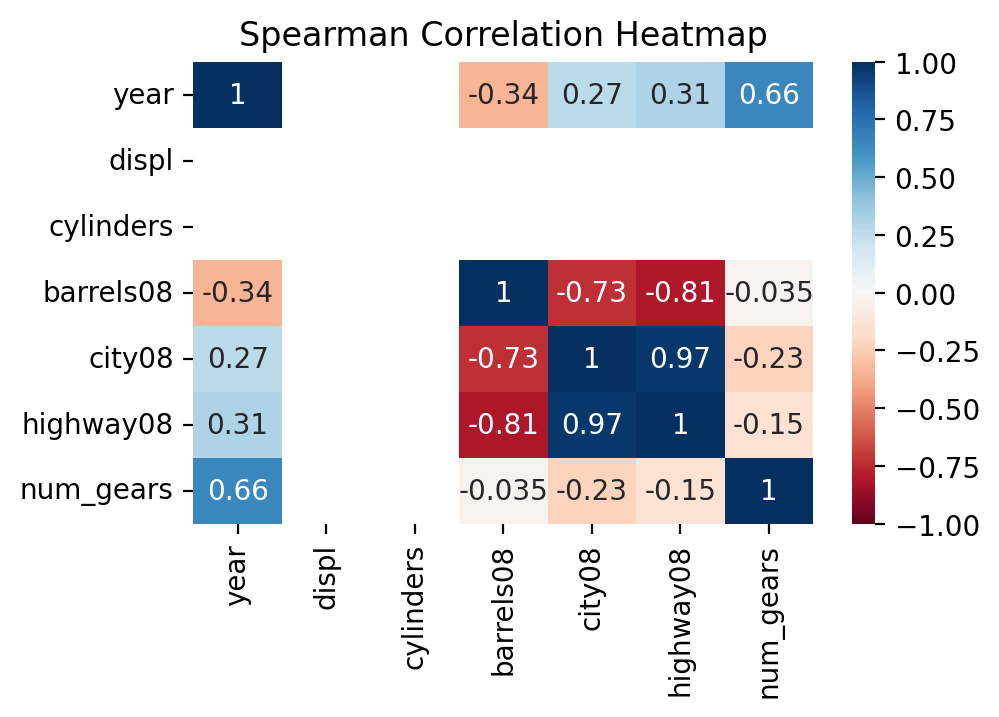

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.heatmap(pl_corr_df, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1, 
            center=0, 
            xticklabels=pl_corr_df_numeric, 
            yticklabels=pl_corr_df_numeric,
            # annot=True
            annot=pl_corr_df
           )
plt.title('Spearman Correlation Heatmap')
plt.show()

## 1.14.3 `corr()` with Pandas
[back to top](#Top)



In practice, using Pandas is more convenient for examining correlations.

* Pandas handles missing values better.
* Pandas has support for the Pearson, Spearman and Kendall correlation coefficients.
* We can color the cells to make it easier to see the correlation coefficients.
* To enable access from Polars to Pandas, use `.to_pandas()`

In [91]:
# Test
(
    tweak_auto(df)
    .to_pandas(
        use_pyarrow_extension_array=True
    )
    .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48202 entries, 0 to 48201
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype                                                             
---  ------        --------------  -----                                                             
 0   year          48202 non-null  int16[pyarrow]                                                    
 1   make          48202 non-null  dictionary<values=large_string, indices=int64, ordered=0>[pyarrow]
 2   model         48202 non-null  dictionary<values=large_string, indices=int64, ordered=0>[pyarrow]
 3   displ         47239 non-null  float[pyarrow]                                                    
 4   cylinders     47237 non-null  uint8[pyarrow]                                                    
 5   trany         48191 non-null  large_string[pyarrow]                                             
 6   drive         47016 non-null  dictionary<values=large_string, indices=

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


In [92]:
(
    tweak_auto(df)
    .to_pandas(use_pyarrow_extension_array=True)
    .corr(method='spearman', numeric_only=True)
    .style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2541424730.py:7: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


,year,displ,cylinders,barrels08,city08,highway08,num_gears
year,1.000000,0.000921,0.017721,-0.313996,0.275952,0.326529,0.723908
displ,0.000921,1.000000,0.928008,0.819792,-0.839134,-0.751833,-0.021957
cylinders,0.017721,0.928008,1.000000,0.779714,-0.810492,-0.701827,0.020363
barrels08,-0.313996,0.819792,0.779714,1.000000,-0.973140,-0.960104,-0.201620
city08,0.275952,-0.839134,-0.810492,-0.973140,1.000000,0.935425,0.167498
highway08,0.326529,-0.751833,-0.701827,-0.960104,0.935425,1.000000,0.230943
num_gears,0.723908,-0.021957,0.020363,-0.201620,0.167498,0.230943,1.000000


---
# 1.15 Being Lazy
[back to top](#Top)

The chaining process we went through was *eager*. We were calculating the results as we went along.

We will now make it lazy. We can make an eager dataframe lazy by using `.lazy()`.

We can also use `pl.scan_csv()` to read the data lazily.

One of the reasons for making it lazy is to enable Polars to use its query optimizer and create a more efficient optimization.

In [93]:
def tweak_auto(df):
    col = ['year', 'make', 'model', 'displ', 'cylinders', 'trany', 'drive', 
           'VClass', 'fuelType', 'barrels08', 'city08', 'highway08', 'createdOn']
    return (
        df
        .select(pl.col(cols))
        .with_columns(
            pl.col('year').cast(pl.Int16),
            pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
            pl.col(['displ', 'barrels08']).cast(pl.Float32),
            pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
            pl.col('createdOn').str.to_datetime('%a %b %d %H:%M:%S %Z %Y'),
            # keywords, like Pandas assign
            is_automatic=pl.col('trany')
                        .str.contains('Automatic')
                        .fill_null('Automatic'),
            num_gears=pl.col('trany')
                        .str.extract(r'(\d+)')
                        .cast(pl.UInt8)
                        .fill_null(6)
                    
        )
    )

Because all of the eager methods used in the tweak function have a lazy equivalent, we can use the existing function and pass in a lazy dataframe, and get a lazy dataframe back.

In [94]:
path = 'data/vehicles.csv'
lazy = pl.scan_csv(path, null_values=['NA'])

tweak_auto(lazy)

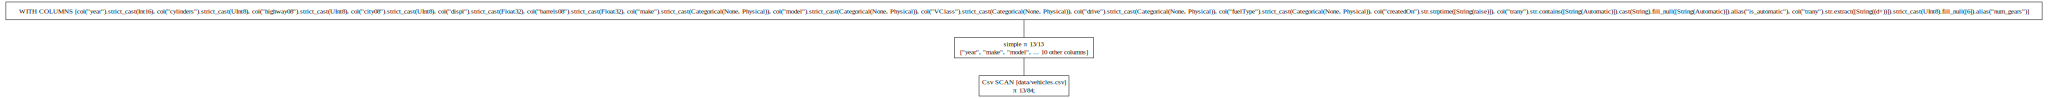

In [95]:
# see the optimized version
tweak_auto(lazy).show_graph()

To execute our lazy dataframe and function, we can add `.collect()` to the end, which indicates we want polars to optimize the chain and execute it.

In [96]:
tweak_auto(lazy).collect()

read files in parallel
avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.
/var/folders/sb/p6dz60l562q8pzfgzf74gsxm0000gn/T/ipykernel_1914/2906562194.py:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  tweak_auto(lazy).collect()


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


---
# 1.16 Chapter Functions and Methods
[back to top](#Top)

See book.